# Analyzing the NYC Subway Dataset

## Section 1: Statistical Test
Statistical test that is choosen to analyze this dataset is the **Mann-Whitney U Test** because as will be seen below, the distribution of the sample is not following a Gaussian or Normal distribution. Therefore, it is appropriate to use Mann-Whitney U test, because unlike Welch's T test, it does not assume that the data come from any probability distribution.

Furthermore, a testing could be conducted to strengthen the decision of using Mann-Whitney U test by performing **Shapiro-Wilk Test**, which will test whether the distribution of the sample is normally distributed.

Moreover, since Mann-Whitney U test only tests whether the two samples come from the same population and not necessarily tells the direction of the test, the test will be a **two-tail test**.

### P-Critical Value
$$P_{\text{Critical}} = .05$$

### Hypotheses
**Null Hypothesis**: The samples of entries on raining days and entries on clear days came from the same general population.
$$H_0: \mu_{\text{Rain}}=\mu_{\text{Clear}}$$

**Alternative Hypothesis**: The samples of entries on on raining days and entries on clear days came from different populations.
$$H_1: \mu_{\text{Rain}}\neq\mu_{\text{Clear}}$$


In [90]:
import pandas as pd
import numpy as np
import scipy.stats

# The path of the dataset CSV file
path = r'improved-dataset/turnstile_weather_v2.csv'

dataFrame = pd.read_csv(path)

# Storing data of entries when rain and when clear
withRain = dataFrame['ENTRIESn_hourly'][dataFrame['rain'] == 1]
withoutRain = dataFrame['ENTRIESn_hourly'][dataFrame['rain'] == 0]

# Calculating means of samples
mean_withRain = np.mean(withRain)
mean_withoutRain = np.mean(withoutRain)

# Calculating Mann-Whitney U Test
U, p = scipy.stats.mannwhitneyu(withRain, withoutRain)

print 'Mean of sample entries when raining: ', mean_withRain
print 'Mean of sample entries when clear: ', mean_withoutRain
print 'Test Statistics (U value): ', U

# P-value is multiplied by 2 because the result from Scipy is from a one-tail test
print 'P-Value: ', p * 2

Mean of sample entries when raining:  2028.19603547
Mean of sample entries when clear:  1845.53943866
Test Statistics (U value):  153635120.5
P-Value:  5.48213914249e-06


### Results
- Null Hypothesis is rejected because:
$$P < P_{\text{Critical}}$$
- It is concluded that there is a probability of less than five percent for obtaining the U value and the samples come from the same population (Less than 5% probability of having a Type-I-Error).
- It is reasonable to conclude that the samples come from different populations and there is a significance difference in number of NYC subway entries when it is raining and when it is not raining.

## Section 2: Linear Regression
### Computation
Computation of the linear regression is conducted using **Statsmodels** and **Ordinary Least Squares** method.

**Input variables** used in this linear regression are these:
  - Hour
  - Day of the Week
  - Rain
  - Average Temperature
  
This linear regression also uses the **unit variable** as a dummy variable to better predict ouput variable.

The input variables are chosen due to that these are the default input variables in the course of Intro to Data Science, except for the 'Day of the Week' variable, and they produce good R-squared value. The computation shows that including 'Day of the Week', instead of 'Precipitation', improves R-squared.

In [86]:
import statsmodels.api as sm

# Function to compute Linear Regression
def linear_regression(features, values):
    '''
    This function takes input and output variables to return
    intercept and parameters as a result of ordinary least
    squares liner regression.
    '''
    # Adding variable to calculate intercept
    features = sm.add_constant(features)
    
    # Calculating linear regression using Ordinary Least Square
    model = sm.OLS(values, features)
    results = model.fit()
    
    # Storing results
    intercept = results.params[0]
    params = results.params[1:]
    
    return intercept, params

# Function to compute predictions
def predictions(features, intercept, params):
    '''
    This function takes input variables and their parameters
    and intercept to compute to return prediction values.
    '''
    return intercept + np.dot(features, params)

# Function to compute R^2
def compute_r_squared(data, predictions):
    '''
    This function takes output variables and predictions values
    to return the computed R Squared value.
    '''
    # Sum of squared difference between data and predictions
    dp_diff = np.square(data - predictions).sum()
    
    # Sum of squared difference between data and its mean
    dmean_diff = np.square(data.map(lambda x: x - np.mean(data))).sum()
    
    r_squared = 1 - (dp_diff / dmean_diff)
    
    return r_squared

# Storing input and output variables that would be used in the model
inputVars = ['hour', 'day_week', 'rain', 'meantempi']
weights = dataFrame[inputVars]
outputs = dataFrame['ENTRIESn_hourly']

# Adding dummy variable to the weights
dummy_units = pd.get_dummies(dataFrame['UNIT'], prefix='unit')
weights = weights.join(dummy_units)

# Compute Linear Regression
intercept, params = linear_regression(weights, outputs)

# Compute prediction values
predictionValues = predictions(weights, intercept, params)

# Compute R Squared
r_squared = compute_r_squared(outputs, predictionValues)

print 'Intercept: ', intercept, '\n'
print 'Parameters:\n', params[:len(inputVars)], '\n'
print 'R Squared: ', r_squared

Intercept:  1946.69132875 

Parameters:
hour         123.329727
day_week    -144.708298
rain          36.169638
meantempi    -14.899818
dtype: float64 

R Squared:  0.470411121826


### Results
The R-squared obtained above is a good measure to tell whether the predictions produce more errors. Therefore, the linear regression obtained above show that the around 47% of the response variable can be explained by the model.

However, the measure of goodness-of-fit might be best calculated with the **standard-error of the regression**, which is not calculated in this analysis, since even a high R-squared value might have a large bias.

## Section 3: Visualization

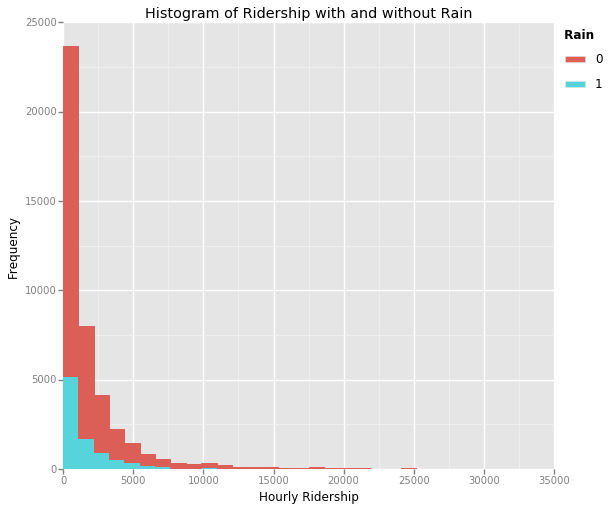

<ggplot: (301081025)>

In [84]:
%matplotlib inline
from ggplot import *

entries_and_rain = dataFrame[['rain', 'ENTRIESn_hourly']]
ggplot(entries_and_rain, aes(x='ENTRIESn_hourly', fill='rain', color='rain')) + geom_histogram() +\
xlab('Hourly Ridership') + ylab('Frequency') + ggtitle('Histogram of Ridership with and without Rain')

The visualization above related to the point made in section 1. Since the histogram above shows that the distributions of the samples are positively skewed, the appropriate test statistics is the Mann-Whitney U test.

Furthermore, it is obvious from the histogram above that the frequency of ridership when there is no rain is much greater than the frequency of ridership when there is rain. This is suggesting that the two samples come from different populations and the mean of population of ridership without rain is greater than the mean of population of ridership with rain.

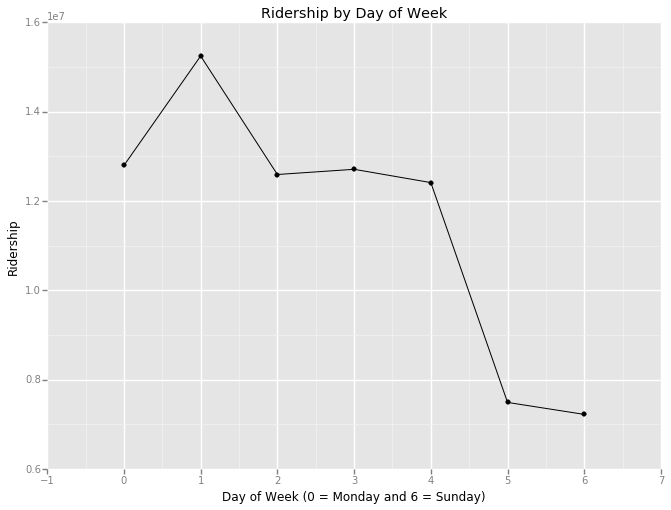

<ggplot: (304018893)>

In [82]:
entries_and_day = dataFrame[['day_week', 'ENTRIESn_hourly']].groupby('day_week',\
                      as_index=False).sum()
ggplot(entries_and_day, aes('day_week', 'ENTRIESn_hourly')) + geom_point() + geom_line() +\
xlab('Day of Week (0 = Monday and 6 = Sunday)') + ylab('Ridership') + ggtitle('Ridership by Day of Week')

The visualization above shows that there is a large difference in ridership between weekdays and weekends. This suggests that it might be the case that the populations from which samples of ridership in weekdays and weekends are sampled respectively are different. It also suggests that the average ridership in weekdays is higher than the one in weekends.

## Section 4: Conclusion

From the statistical test conducted, it can be concluded that the population on which the samples of ridership with rain is different from the population on which the samples of ridership without rain. Since the Mann-Whitney U test only tests for two-tail and does not test in any direction, it cannot be concluded whether more people ride te NYC subway when it is raining.

Nevertheless, the histogram in section 3 shows that the frequency of samples' ridership with rain is far greater that the one with ridership without rain. This suggests that it might be the case that more people ride NYC subway when it is not raining.

## Section 5: Reflection
### Dataset Shortcomings
The dataset might not include a comprehensive image of NYC ridership since the data are only sampled from the month of May and not the entire year. An entire year sample could control some confounding variables such as some holidays in May that might influence the result or the influence of weather season on ridership.

Furthermore, the dataset does not include a complete data for every hour and instead only provide data for every four hours. This might also influence the result since it would not control some confounding variables.

### Analysis Shortcomings
#### Mann-Whitney U Test
The usage of Mann-Whitney U Test has a shortcoming which is that it only tests for a two-tail and therefore the analysis could not conclude whether the means of populations from which the samples come from is higher than the other.

Moreover, the P-value result of Mann-Whitney U test obtained from Scipy is a result of a one-tail test instead of two-tail test. This shortcoming can be overcome by multiplying the obtained P-value by two to result in the P-value of a two-tail Mann-Whitney U test.

#### R-Squared Value
R-squared only measure the error of the linear model's predictions. It cannot be a reliable measure to tell the goodness-of-fit because it alone cannot account for biases that might occur. To better measure the goodness-of-fit of the model obtained, it would be better to use the standard-error of the regression.